<a href="https://colab.research.google.com/github/nht0017/HIDS/blob/main/CICIDS_multiclassipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf

from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
from glob import glob
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split

import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, accuracy_score, roc_curve, auc, recall_score, precision_score,plot_confusion_matrix


## **Get Data from Kaggle**

In [2]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d cicdataset/cicids2017

! unzip cicids2017.zip

Saving kaggle.json to kaggle.json
 95% 219M/230M [00:02<00:00, 93.2MB/s]
100% 230M/230M [00:02<00:00, 109MB/s] 
Archive:  cicids2017.zip
  inflating: MachineLearningCSV.md5  
  inflating: MachineLearningCSV/MachineLearningCVE/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv  
  inflating: MachineLearningCSV/MachineLearningCVE/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv  
  inflating: MachineLearningCSV/MachineLearningCVE/Friday-WorkingHours-Morning.pcap_ISCX.csv  
  inflating: MachineLearningCSV/MachineLearningCVE/Monday-WorkingHours.pcap_ISCX.csv  
  inflating: MachineLearningCSV/MachineLearningCVE/Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv  
  inflating: MachineLearningCSV/MachineLearningCVE/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv  
  inflating: MachineLearningCSV/MachineLearningCVE/Tuesday-WorkingHours.pcap_ISCX.csv  
  inflating: MachineLearningCSV/MachineLearningCVE/Wednesday-workingHours.pcap_ISCX.csv  


# **Data Process**

In [3]:
# Get a list of files from this dir
files_list = os.listdir('MachineLearningCSV/MachineLearningCVE/')

files_list.sort()

files_list

['Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv',
 'Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv',
 'Friday-WorkingHours-Morning.pcap_ISCX.csv',
 'Monday-WorkingHours.pcap_ISCX.csv',
 'Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv',
 'Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv',
 'Tuesday-WorkingHours.pcap_ISCX.csv',
 'Wednesday-workingHours.pcap_ISCX.csv']

## **Read in Data**

Enter INDEX number within files_list to read in that dataframe

In [138]:
INDEX =  0#@param {type:"integer"}

# Get df name
DATA = files_list[INDEX].split('.', 1)[0]
print('DATA:', DATA)
# Read in df
df = pd.read_csv('MachineLearningCSV/MachineLearningCVE/'+str(files_list[INDEX]), sep=',', header=0, engine='python')

df

DATA: Friday-WorkingHours-Afternoon-DDos


,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Header Length.1,Fwd Avg Bytes/Bulk,Fwd Avg Packets/Bulk,Fwd Avg Bulk Rate,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,54865,3,2,0,12,0,6,6,6.0,0.0,0,0,0.0,0.0,4.000000e+06,666666.66670,3.0,0.0,3,3,3,3.0,0.0,3,3,0,0.0,0.0,0,0,0,0,0,0,40,0,666666.666700,0.000000,6,6,6.0,0.0,0.0,0,0,0,0,1,0,0,0,0,9.0,6.0,0.0,40,0,0,0,0,0,0,2,12,0,0,33,-1,1,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,55054,109,1,1,6,6,6,6,6.0,0.0,6,6,6.0,0.0,1.100917e+05,18348.62385,109.0,0.0,109,109,0,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0,0,0,20,20,9174.311927,9174.311927,6,6,6.0,0.0,0.0,0,0,0,0,1,1,0,0,1,9.0,6.0,6.0,20,0,0,0,0,0,0,1,6,1,6,29,256,0,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,55055,52,1,1,6,6,6,6,6.0,0.0,6,6,6.0,0.0,2.307692e+05,38461.53846,52.0,0.0,52,52,0,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0,0,0,20,20,19230.769230,19230.769230,6,6,6.0,0.0,0.0,0,0,0,0,1,1,0,0,1,9.0,6.0,6.0,20,0,0,0,0,0,0,1,6,1,6,29,256,0,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,46236,34,1,1,6,6,6,6,6.0,0.0,6,6,6.0,0.0,3.529412e+05,58823.52941,34.0,0.0,34,34,0,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0,0,0,20,20,29411.764710,29411.764710,6,6,6.0,0.0,0.0,0,0,0,0,1,1,0,0,1,9.0,6.0,6.0,20,0,0,0,0,0,0,1,6,1,6,31,329,0,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,54863,3,2,0,12,0,6,6,6.0,0.0,0,0,0.0,0.0,4.000000e+06,666666.66670,3.0,0.0,3,3,3,3.0,0.0,3,3,0,0.0,0.0,0,0,0,0,0,0,40,0,666666.666700,0.000000,6,6,6.0,0.0,0.0,0,0,0,0,1,0,0,0,0,9.0,6.0,0.0,40,0,0,0,0,0,0,2,12,0,0,32,-1,1,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225740,61374,61,1,1,6,6,6,6,6.0,0.0,6,6,6.0,0.0,1.967213e+05,32786.88525,61.0,0.0,61,61,0,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0,0,0,20,20,16393.442620,16393.442620,6,6,6.0,0.0,0.0,0,0,0,0,1,1,0,0,1,9.0,6.0,6.0,20,0,0,0,0,0,0,1,6,1,6,288,253,0,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
225741,61378,72,1,1,6,6,6,6,6.0,0.0,6,6,6.0,0.0,1.666667e+05,27777.77778,72.0,0.0,72,72,0,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0,0,0,20,20,13888.888890,13888.888890,6,6,6.0,0.0,0.0,0,0,0,0,1,1,0,0,1,9.0,6.0,6.0,20,0,0,0,0,0,0,1,6,1,6,288,253,0,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
225742,61375,75,1,1,6,6,6,6,6.0,0.0,6,6,6.0,0.0,1.600000e+05,26666.66667,75.0,0.0,75,75,0,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0,0,0,20,20,13333.333330,13333.333330,6,6,6.0,0.0,0.0,0,0,0,0,1,1,0,0,1,9.0,6.0,6.0,20,0,0,0,0,0,0,1,6,1,6,288,253,0,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
225743,61323,48,2,0,12,0,6,6,6.0,0.0,0,0,0.0,0.0,2.500000e+05,41666.66667,48.0,0.0,48,48,48,48.0,0.0,48,48,0,0.0,0.0,0,0,0,0,0,0,40,0,41666.666670,0.000000,6,6,6.0,0.0,0.0,0,0,0,0,1,0,0,0,0,9.0,6.0,0.0,40,0,0,0,0,0,0,2,12,0,0,4719,-1,1,20,0.0,0.0,0,0,0.0,0.

In [139]:
df.describe()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Header Length.1,Fwd Avg Bytes/Bulk,Fwd Avg Packets/Bulk,Fwd Avg Bulk Rate,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
count,225745.00000,2.257450e+05,225745.000000,225745.000000,225745.000000,2.257450e+05,225745.000000,225745.000000,225745.000000,225745.000000,225745.000000,225745.000000,225745.000000,225745.000000,2.257410e+05,2.257450e+05,2.257450e+05,2.257450e+05,2.257450e+05,2.257450e+05,2.257450e+05,2.257450e+05,2.257450e+05,2.257450e+05,2.257450e+05,2.257450e+05,2.257450e+05,2.257450e+05,2.257450e+05,2.257450e+05,225745.000000,225745.0,225745.0,225745.0,225745.000000,225745.000000,2.257450e+05,2.257450e+05,225745.000000,225745.000000,225745.000000,225745.000000,2.257450e+05,225745.000000,225745.000000,225745.000000,225745.000000,225745.000000,225745.000000,225745.0,225745.000000,225745.000000,225745.000000,225745.000000,225745.000000,225745.000000,225745.0,225745.0,225745.0,225745.0,225745.0,225745.0,225745.000000,225745.000000,225745.000000,2.257450e+05,225745.000000,225745.000000,225745.000000,225745.000000,2.257450e+05,2.257450e+05,2.257450e+05,2.257450e+05,2.257450e+05,2.257450e+05,2.257450e+05,2.257450e+05
mean,8879.61946,1.624165e+07,4.874916,4.572775,939.463346,5.960477e+03,538.535693,27.882221,164.826715,214.907242,2735.585147,16.718776,890.536849,1230.172938,inf,inf,1.580587e+06,4.248569e+06,1.348977e+07,2.811855e+04,1.539652e+07,2.540610e+06,5.195207e+06,1.299434e+07,2.073698e+05,6.564701e+06,9.476322e+05,1.610306e+06,4.567514e+06,2.257817e+05,0.033223,0.0,0.0,0.0,111.522718,106.789023,1.261508e+04,1.641693e+03,8.072595,3226.045339,515.002137,1085.593207,2.789906e+06,0.002671,0.033223,0.000120,0.351162,0.504463,0.140752,0.0,0.000120,1.005821,574.568843,164.826715,890.536849,111.522718,0.0,0.0,0.0,0.0,0.0,0.0,4.874916,939.463346,4.572775,5.960477e+03,4247.436922,601.048635,3.311497,21.482753,1.848261e+05,1.293436e+04,2.080849e+05,1.776201e+05,1.032214e+07,3.611943e+06,1.287813e+07,7.755355e+06
std,19754.64740,3.152437e+07,15.422874,21.755356,3249.403484,3.921834e+04,1864.128991,163.324159,504.892965,797.411073,3705.123460,50.480568,1120.324921,1733.201267,NaN,NaN,2.701596e+06,7.622819e+06,2.670172e+07,7.598100e+05,3.160826e+07,5.934694e+06,1.078635e+07,2.748870e+07,3.795228e+06,2.198455e+07,4.586374e+06,5.475778e+06,1.617865e+07,4.019290e+06,0.179220,0.0,0.0,0.0,375.790727,511.765795,1.106701e+05,1.989593e+04,15.767713,3813.134850,559.064495,1269.558714,4.115941e+06,0.051614,0.179220,0.010936,0.477334,0.499981,0.347766,0.0,0.010936,1.430781,626.096202,504.892965,1120.324921,375.790727,0.0,0.0,0.0,0.0,0.0,0.0,15.422874,3249.403484,21.755356,3.921834e+04,8037.781019,4319.720339,12.270018,4.166799,7.979250e+05,2.102737e+05,9.002350e+05,7.842602e+05,2.185303e+07,1.275689e+07,2.692126e+07,1.983109e+07
min,0.00000,-1.000000e+00,1.000000,0.000000,0.000000

**Check for columns with only constant**

If Label only has 1 value, then we don't analyze this df.


In [140]:
# Print a list of column containing only constant if exists
filt = np.std(df, axis=0) == 0

if filt.any == True:
  print(df.loc[:,filt])

Monday-WorkingHour only has normal class. Therefore, we do not run the algorithms on this dataset.


In [141]:
df.columns

Index([' Destination Port', ' Flow Duration', ' Total Fwd Packets',
       ' Total Backward Packets', 'Total Length of Fwd Packets',
       ' Total Length of Bwd Packets', ' Fwd Packet Length Max',
       ' Fwd Packet Length Min', ' Fwd Packet Length Mean',
       ' Fwd Packet Length Std', 'Bwd Packet Length Max',
       ' Bwd Packet Length Min', ' Bwd Packet Length Mean',
       ' Bwd Packet Length Std', 'Flow Bytes/s', ' Flow Packets/s',
       ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max', ' Flow IAT Min',
       'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std', ' Fwd IAT Max',
       ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean', ' Bwd IAT Std',
       ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags', ' Bwd PSH Flags',
       ' Fwd URG Flags', ' Bwd URG Flags', ' Fwd Header Length',
       ' Bwd Header Length', 'Fwd Packets/s', ' Bwd Packets/s',
       ' Min Packet Length', ' Max Packet Length', ' Packet Length Mean',
       ' Packet Length Std', ' Packet Length Variance', '

## **Encoding Label**

In [142]:
# Look for classes have < 2 instances --> drop it

filt = df[' Label'].value_counts() < 2

if filt.any == True: # If there is any class has < 2 instances
  for i in range(len(filt)):
    if filt[i]:
      #print(i)
      drop_class = filt[filt == True].index[i] # Assuming only 1 class has 1 instance
      print('A class with only 1 instance is ',drop_class)
      print('df shape before dropping:', df.shape)

      # Filter only classes that have only 1 instance and then drop it.
      class_filt = df[' Label'] == drop_class
      df.drop(index = df[class_filt].index , inplace=True) 
      print('df shape after dropping:', df.shape)
else:
  print('No Class < 2 instances')

No Class < 2 instances


In [143]:
OG_labels = sorted( list(df[' Label'].unique() ))
print('Before encoding Label: ', OG_labels)
df[' Label'] = df[' Label'].astype("category").cat.codes

encoded_labels = sorted( list(df[' Label'].unique()))
print('After encoding Label: ', encoded_labels)

OG_y = df[' Label'] 
n_classes = len(OG_y.unique())

Before encoding Label:  ['BENIGN', 'DDoS']
After encoding Label:  [0, 1]


In [144]:
labels_dict = dict(zip(encoded_labels, OG_labels))
labels_dict

{0: 'BENIGN', 1: 'DDoS'}

**Check if the df has infinity value**
if Yes, replace it with NaN value so that we can drop it altogether in a bit


In [145]:
print('Has inf value?', np.any(np.isinf(df)))
if  np.any(np.isinf(df)):
  df.replace([np.inf, -np.inf], np.nan, inplace=True)

print('BEFORE removing NaN', df.shape)

# Removing NaN
df.dropna(axis=1, how='any', inplace=True)

print('AFTER removing NaN', df.shape)
print('Has NaN value?',np.any(np.isnan(df)))

Has inf value? True
BEFORE removing NaN (225745, 79)
AFTER removing NaN (225745, 77)
Has NaN value? False


## **Features Selection**

In [146]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif, chi2


r,c = df.shape
X = df.iloc[:,:c-1]
y = df[' Label']

bestfeatures = SelectKBest(score_func=f_classif, k=10)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
best_features = featureScores.nlargest(30,'Score')
best_features  #print 30 best features

/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [29 30 31 47 54 55 56 57 58 59] are constant.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


,Specs,Score
12,Bwd Packet Length Mean,129182.039989
52,Avg Bwd Segment Size,129182.039989
10,Bwd Packet Length Max,112855.799091
13,Bwd Packet Length Std,112172.559084
0,Destination Port,79271.596321
46,URG Flag Count,61660.948347
38,Packet Length Mean,58701.852848
50,Average Packet Size,58438.166817
39,Packet Length Std,55351.220164
36,Min Packet Length,50451.862386


In [147]:
# Enter SCORE as a lower limit to choose features
SCORE =  500#@param {type:"integer"}
best_column_indices = []

# Choose any features with scores above 1000
for index, row in best_features.iterrows():
  print(row[ "Score"])
  if row[ "Score"] > SCORE :
    best_column_indices.append(index)

X = X.iloc[:, best_column_indices]

X 

129182.03998907402
129182.03998906647
112855.79909131919
112172.55908401245
79271.59632089351
61660.94834720282
58701.852848306415
58438.166817468635
55351.22016403106
50451.86238587292
46803.422513088604
45106.278108111575
44901.45786400244
34843.75352546932
32950.821578486255
32950.821578486255
26028.288049863837
25698.2686942641
25698.2686942641
25517.125555175866
23211.246826548842
22370.57049592308
21050.302018478713
20868.312349609692
14760.914479848443
10643.042331177545
10643.042331177545
10269.339050961753
7567.1563706922625
3858.224092920183


,Bwd Packet Length Mean,Avg Bwd Segment Size,Bwd Packet Length Max,Bwd Packet Length Std,Destination Port,URG Flag Count,Packet Length Mean,Average Packet Size,Packet Length Std,Min Packet Length,Max Packet Length,Packet Length Variance,min_seg_size_forward,Bwd Packet Length Min,Fwd Packet Length Mean,Avg Fwd Segment Size,Fwd Packet Length Max,Total Length of Fwd Packets,Subflow Fwd Bytes,Bwd IAT Total,Down/Up Ratio,Fwd Packet Length Std,Bwd IAT Max,Bwd IAT Std,PSH Flag Count,Fwd PSH Flags,SYN Flag Count,Bwd IAT Mean,Fwd Packet Length Min,Flow IAT Std
0,0.0,0.0,0,0.0,54865,0,6.0,9.0,0.0,6,6,0.0,20,0,6.0,6.0,6,12,12,0,0,0.0,0,0.0,0,0,0,0.0,6,0.0
1,6.0,6.0,6,0.0,55054,1,6.0,9.0,0.0,6,6,0.0,20,6,6.0,6.0,6,6,6,0,1,0.0,0,0.0,0,0,0,0.0,6,0.0
2,6.0,6.0,6,0.0,55055,1,6.0,9.0,0.0,6,6,0.0,20,6,6.0,6.0,6,6,6,0,1,0.0,0,0.0,0,0,0,0.0,6,0.0
3,6.0,6.0,6,0.0,46236,1,6.0,9.0,0.0,6,6,0.0,20,6,6.0,6.0,6,6,6,0,1,0.0,0,0.0,0,0,0,0.0,6,0.0
4,0.0,0.0,0,0.0,54863,0,6.0,9.0,0.0,6,6,0.0,20,0,6.0,6.0,6,12,12,0,0,0.0,0,0.0,0,0,0,0.0,6,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225740,6.0,6.0,6,0.0,61374,1,6.0,9.0,0.0,6,6,0.0,20,6,6.0,6.0,6,6,6,0,1,0.0,0,0.0,0,0,0,0.0,6,0.0
225741,6.0,6.0,6,0.0,61378,1,6.0,9.0,0.0,6,6,0.0,20,6,6.0,6.0,6,6,6,0,1,0.0,0,0.0,0,0,0,0.0,6,0.0
225742,6.0,6.0,6,0.0,61375,1,6.0,9.0,0.0,6,6,0.0,20,6,6.0,6.0,6,6,6,0,1,0.0,0,0.0,0,0,0,0.0,6,0.0
225743,0.0,0.0,0,0.0,61323,0,6.0,9.0,0.0,6,6,0.0,20,0,6.0,6.0,6,12,12,0,0,0.0,0,0.0,0,0,0,0.0,6,0.0


In [148]:
X.describe()

,Bwd Packet Length Mean,Avg Bwd Segment Size,Bwd Packet Length Max,Bwd Packet Length Std,Destination Port,URG Flag Count,Packet Length Mean,Average Packet Size,Packet Length Std,Min Packet Length,Max Packet Length,Packet Length Variance,min_seg_size_forward,Bwd Packet Length Min,Fwd Packet Length Mean,Avg Fwd Segment Size,Fwd Packet Length Max,Total Length of Fwd Packets,Subflow Fwd Bytes,Bwd IAT Total,Down/Up Ratio,Fwd Packet Length Std,Bwd IAT Max,Bwd IAT Std,PSH Flag Count,Fwd PSH Flags,SYN Flag Count,Bwd IAT Mean,Fwd Packet Length Min,Flow IAT Std
count,225745.000000,225745.000000,225745.000000,225745.000000,225745.00000,225745.000000,225745.000000,225745.000000,225745.000000,225745.000000,225745.000000,2.257450e+05,225745.000000,225745.000000,225745.000000,225745.000000,225745.000000,225745.000000,225745.000000,2.257450e+05,225745.000000,225745.000000,2.257450e+05,2.257450e+05,225745.000000,225745.000000,225745.000000,2.257450e+05,225745.000000,2.257450e+05
mean,890.536849,890.536849,2735.585147,1230.172938,8879.61946,0.140752,515.002137,574.568843,1085.593207,8.072595,3226.045339,2.789906e+06,21.482753,16.718776,164.826715,164.826715,538.535693,939.463346,939.463346,6.564701e+06,1.005821,214.907242,4.567514e+06,1.610306e+06,0.351162,0.033223,0.033223,9.476322e+05,27.882221,4.248569e+06
std,1120.324921,1120.324921,3705.123460,1733.201267,19754.64740,0.347766,559.064495,626.096202,1269.558714,15.767713,3813.134850,4.115941e+06,4.166799,50.480568,504.892965,504.892965,1864.128991,3249.403484,3249.403484,2.198455e+07,1.430781,797.411073,1.617865e+07,5.475778e+06,0.477334,0.179220,0.179220,4.586374e+06,163.324159,7.622819e+06
min,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00
25%,0.000000,0.000000,0.000000,0.000000,80.00000,0.000000,6.000000,7.500000,0.000000,0.000000,6.000000,0.000000e+00,20.000000,0.000000,6.000000,6.000000,6.000000,26.000000,26.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,1.910446e+04
50%,92.000000,92.000000,99.000000,2.449490,80.00000,0.000000,110.333333,141.000000,154.030812,0.000000,513.000000,2.372549e+04,20.000000,0.000000,8.666667,8.666667,20.000000,30.000000,30.000000,4.110100e+04,1.000000,5.301991,3.336500e+04,1.470372e+04,0.000000,0.000000,0.000000,1.000940e+04,0.000000,5.641676e+05
75%,1934.500000,1934.500000,5840.000000,2436.833027,80.00000,0.000000,1162.700000,1291.888889,2131.870960,6.000000,5840.000000,4.544874e+06,20.000000,6.000000,32.000000,32.000000,34.000000,63.000000,63.000000,1.111677e+06,1.000000,10.263203,1.094045e+06,5.177920e+05,1.000000,0.000000,0.000000,2.655838e+05,6.000000,4.033232e+06
max,5800.500000,5800.500000,11680.000000,8194.660487,65532.00000,1.000000,1936.833333,2528.000000,4731.522394,337.000000,11680.000000,2.240000e+07,52.000000,1460.000000,3867.000000,3867.000000,11680.000000,183012.000000,183012.000000,1.200000e+08,7.000000,6692.644993,1.200000e+08,7.670000e+07,1.000000,1.000000,1.000000,1.200000e+08,1472.000000,6.920000e+07


## **Data Cleaning**

In [149]:
label_range = np.arange(0, np.max(y.unique())+1)

label_range

array([0, 1])

Class 0 - BENIGN: n=97718 (43.287%)
---------> Major class 0
Class 1 - DDoS: n=128027 (56.713%)
---------> Major class 1


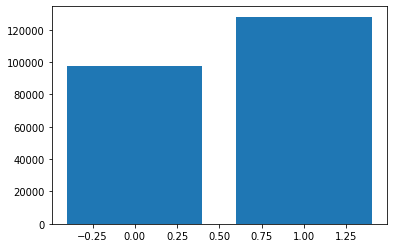

In [150]:
from collections import Counter

sub_X = pd.DataFrame()
MAX_CASES = 1

# summarize distribution
counter = Counter(df[' Label'])
for k,v in counter.items():
  per = v / len(df[' Label']) * 100
  print('Class %s - %s: n=%d (%.3f%%)' % (k, labels_dict[k], v, per))
  if v > MAX_CASES:
    MAX_CASES = v
    biggest_class = k
    print('---------> Major class %d'% k)

# plot the distribution
plt.bar(counter.keys(), counter.values())
plt.show()

Separating normal observations from intrusion ones. That way, if the dataset is imbalanced, we can easily bootstrap either class.

### **Removing duplicates from multiple classes**

- Separate each class into a df
- Remove duplicate rows that exist in multiple classes


In [151]:
# Rename column to integers
X.set_axis(np.arange(0, len(X.columns)), axis=1, inplace=True)

# Filter out normal class and different attacks and put them in separate dfs
data = []
for label in encoded_labels:
  filt = y == label
  data.append( X.loc[filt] )
  
# condense data from each class into different sets
class_set = {}
index = 0
for item in data:
  #print(item)
  class_list = item.values.tolist()
  class_set[index] = set(tuple(i) for i in class_list)
  index += 1

# print original sets lengths
print( 'Before cleaning:')
for key, value in class_set.items():
  print( 'Class %d len: %d' % (key, len(value)) )

Before cleaning:
Class 0 len: 84245
Class 1 len: 127452


**When take the difference between multiple sets like (A - B - C), the result contain only A rows that doesn't exist in B nor C**

In [152]:
# Take the differences between 1 class and the others:
def difference_per_class ( class_number ):
  diff = class_set[class_number]
  for i in range(len(class_set)):
    # Normal class must be differentiated from all intrusion classes:
    #if class_number == NORMAL_CLASS_INDEX and i != class_number:
    #  diff -= class_set[i]
      #print('*************** NORMAL CLASS ALERT!!!!')
    #else:
      if i > class_number:
        diff -= class_set[i] 
  return diff

# Get the differences of all classes:
cleaned_class_set = {}
for key in class_set:
  cleaned_class_set[key] = difference_per_class(key)

print( 'After cleaning:')
MAX_CASES = 0
MAX_CLASS = 0
for key, value in cleaned_class_set.items():
  print( 'Class %d len: %d' % (key, len(value)) )
  if len(value) > MAX_CASES:
    MAX_CASES = len(value)
    MAX_CLASS = key

print('MAX CLASS %d has %d cases'% (MAX_CLASS, MAX_CASES))

After cleaning:
Class 0 len: 84242
Class 1 len: 127452
MAX CLASS 1 has 127452 cases


In [153]:
# Append data from minor classes into 1 dataframe sub_X
sub_X = pd.DataFrame()
for key in cleaned_class_set:
  if key != MAX_CLASS:
    data_per_class = pd.DataFrame(cleaned_class_set[key])
    data_per_class['Labels'] = np.ones( len(cleaned_class_set[key]), dtype=int )*key  # The label value is the key value
    sub_X = sub_X.append(data_per_class, ignore_index=True)

# Append data from major class into major_X
major_X = pd.DataFrame(cleaned_class_set[MAX_CLASS])
major_X['Labels'] = MAX_CLASS
major_X

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,Labels
0,2901.75,2901.75,11595.0,5795.500690,80.0,0.0,897.615385,972.416667,3214.167532,0.0,11595.0,1.030000e+07,20.0,0.0,7.000000,7.000000,20.0,56.0,56.0,200818.0,0.0,5.656854,199950.0,115191.41890,0.0,0.0,0.0,66939.33333,0.0,2.720000e+07,1
1,2900.25,2900.25,10135.0,4871.825830,80.0,0.0,897.153846,971.916667,2804.564846,0.0,10135.0,7.865584e+06,20.0,0.0,7.000000,7.000000,20.0,56.0,56.0,31694.0,0.0,5.656854,21199.0,10504.50096,0.0,0.0,0.0,10564.66667,0.0,1.990000e+07,1
2,0.00,0.00,0.0,0.000000,80.0,0.0,6.000000,7.000000,0.000000,6.0,6.0,0.000000e+00,20.0,0.0,6.000000,6.000000,6.0,36.0,36.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.00000,6.0,4.024011e+06,1
3,0.00,0.00,0.0,0.000000,80.0,0.0,6.000000,7.500000,0.000000,6.0,6.0,0.000000e+00,20.0,0.0,6.000000,6.000000,6.0,24.0,24.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.00000,6.0,6.291790e+06,1
4,1934.50,1934.50,4380.0,2177.344966,80.0,0.0,1163.300000,1292.555556,1903.962654,0.0,4380.0,3.625074e+06,20.0,0.0,8.666667,8.666667,20.0,26.0,26.0,622029.0,2.0,10.263203,621133.0,277679.05700,1.0,0.0,0.0,124405.80000,0.0,2.195555e+05,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127447,2900.25,2900.25,8760.0,4128.319301,80.0,0.0,1453.375000,1661.000000,3113.952607,0.0,8760.0,9.696701e+06,20.0,0.0,8.666667,8.666667,20.0,26.0,26.0,53215.0,1.0,10.263203,37059.0,18420.57915,1.0,0.0,0.0,17738.33333,0.0,1.508721e+04,1
127448,2321.40,2321.40,8760.0,3802.315321,80.0,0.0,1453.375000,1661.000000,3113.952607,0.0,8760.0,9.696701e+06,20.0,0.0,10.000000,10.000000,20.0,20.0,20.0,1766916.0,2.0,14.142136,1765889.0,882773.41150,1.0,0.0,0.0,441729.00000,0.0,7.208336e+05,1
127449,2900.25,2900.25,8760.0,4128.319301,80.0,0.0,897.153846,971.916667,2488.507044,0.0,8760.0,6.192667e+06,20.0,0.0,7.000000,7.000000,20.0,56.0,56.0,295027.0,0.0,5.656854,276376.0,154452.56050,0.0,0.0,0.0,98342.33333,0.0,1.970000e+07,1
127450,1933.50,1933.50,4380.0,1757.789948,80.0,0.0,1162.700000,1291.888889,1645.241762,0.0,4380.0,2.706820e+06,20.0,0.0,8.666667,8.666667,20.0,26.0,26.0,37634.0,2.0,10.263203,37089.0,16526.06596,1.0,0.0,0.0,7526.80000,0.0,1.306288e+04,1


In [154]:
sub_X

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,Labels
0,6.000000,6.000000,6.0,0.000000,38388.0,1.0,6.000000,7.000000,0.000000,6.0,6.0,0.000000e+00,20.0,6.0,6.000000,6.000000,6.0,6.0,6.0,9087747.0,5.0,0.000000,9067757.0,4.530555e+06,0.0,0.0,0.0,2.271937e+06,6.0,4.052860e+06,0
1,246.923077,246.923077,1448.0,534.949446,443.0,0.0,137.100000,141.827586,374.319921,0.0,1448.0,1.401154e+05,32.0,0.0,56.437500,56.437500,592.0,903.0,903.0,60800000.0,0.0,152.665634,10100000.0,5.229899e+06,1.0,0.0,0.0,5.063504e+06,0.0,4.170606e+06,0
2,129.000000,129.000000,129.0,0.000000,53.0,0.0,70.800000,88.500000,53.129088,32.0,129.0,2.822700e+03,40.0,129.0,32.000000,32.000000,32.0,64.0,64.0,1.0,1.0,0.000000,1.0,0.000000e+00,0.0,0.0,0.0,1.000000e+00,32.0,1.374130e+02,0
3,135.000000,135.000000,135.0,0.000000,53.0,0.0,77.400000,96.750000,52.581366,39.0,135.0,2.764800e+03,32.0,135.0,39.000000,39.000000,39.0,78.0,78.0,3.0,1.0,0.000000,3.0,0.000000e+00,0.0,0.0,0.0,3.000000e+00,39.0,9.901683e+01,0
4,49.000000,49.000000,49.0,0.000000,53.0,0.0,39.400000,49.250000,8.763561,33.0,49.0,7.680000e+01,32.0,49.0,33.000000,33.000000,33.0,66.0,66.0,49.0,1.0,0.000000,49.0,0.000000e+00,0.0,0.0,0.0,4.900000e+01,33.0,9.712020e+01,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84237,105.250000,105.250000,421.0,210.500000,80.0,0.0,133.750000,152.857143,255.043274,0.0,649.0,6.504707e+04,32.0,0.0,216.333333,216.333333,649.0,649.0,649.0,223059.0,1.0,374.700325,221941.0,1.278162e+05,1.0,0.0,0.0,7.435300e+04,0.0,1.162643e+05,0
84238,6.000000,6.000000,6.0,0.000000,29130.0,1.0,6.000000,7.000000,0.000000,6.0,6.0,0.000000e+00,20.0,6.0,6.000000,6.000000,6.0,6.0,6.0,4169061.0,5.0,0.000000,4165002.0,2.081825e+06,0.0,0.0,0.0,1.042265e+06,6.0,1.861831e+06,0
84239,6.888889,6.888889,20.0,5.301991,63481.0,1.0,687.117647,730.062500,1707.681172,0.0,5840.0,2.916175e+06,20.0,0.0,1659.000000,1659.000000,5840.0,11613.0,11613.0,101000000.0,1.0,2429.621575,90900000.0,3.180000e+07,0.0,0.0,0.0,1.260000e+07,0.0,2.340000e+07,0
84240,49.000000,49.000000,49.0,0.000000,53.0,0.0,39.400000,49.250000,8.763561,33.0,49.0,7.680000e+01,20.0,49.0,33.000000,33.000000,33.0,66.0,66.0,1.0,1.0,0.000000,1.0,0.000000e+00,0.0,0.0,0.0,1.000000e+00,33.0,8.155366e+01,0


In [155]:
# Append major_X into sub_X to create X w/o bootstrapping
X = sub_X.append(major_X)

# Reset index and then save Labels into y
X.reset_index(drop=True, inplace=True)
y = X['Labels']
X.drop(columns=['Labels'], inplace= True)

X

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
0,6.000000,6.000000,6.0,0.000000,38388.0,1.0,6.000000,7.000000,0.000000,6.0,6.0,0.000000e+00,20.0,6.0,6.000000,6.000000,6.0,6.0,6.0,9087747.0,5.0,0.000000,9067757.0,4.530555e+06,0.0,0.0,0.0,2.271937e+06,6.0,4.052860e+06
1,246.923077,246.923077,1448.0,534.949446,443.0,0.0,137.100000,141.827586,374.319921,0.0,1448.0,1.401154e+05,32.0,0.0,56.437500,56.437500,592.0,903.0,903.0,60800000.0,0.0,152.665634,10100000.0,5.229899e+06,1.0,0.0,0.0,5.063504e+06,0.0,4.170606e+06
2,129.000000,129.000000,129.0,0.000000,53.0,0.0,70.800000,88.500000,53.129088,32.0,129.0,2.822700e+03,40.0,129.0,32.000000,32.000000,32.0,64.0,64.0,1.0,1.0,0.000000,1.0,0.000000e+00,0.0,0.0,0.0,1.000000e+00,32.0,1.374130e+02
3,135.000000,135.000000,135.0,0.000000,53.0,0.0,77.400000,96.750000,52.581366,39.0,135.0,2.764800e+03,32.0,135.0,39.000000,39.000000,39.0,78.0,78.0,3.0,1.0,0.000000,3.0,0.000000e+00,0.0,0.0,0.0,3.000000e+00,39.0,9.901683e+01
4,49.000000,49.000000,49.0,0.000000,53.0,0.0,39.400000,49.250000,8.763561,33.0,49.0,7.680000e+01,32.0,49.0,33.000000,33.000000,33.0,66.0,66.0,49.0,1.0,0.000000,49.0,0.000000e+00,0.0,0.0,0.0,4.900000e+01,33.0,9.712020e+01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211689,2900.250000,2900.250000,8760.0,4128.319301,80.0,0.0,1453.375000,1661.000000,3113.952607,0.0,8760.0,9.696701e+06,20.0,0.0,8.666667,8.666667,20.0,26.0,26.0,53215.0,1.0,10.263203,37059.0,1.842058e+04,1.0,0.0,0.0,1.773833e+04,0.0,1.508721e+04
211690,2321.400000,2321.400000,8760.0,3802.315321,80.0,0.0,1453.375000,1661.000000,3113.952607,0.0,8760.0,9.696701e+06,20.0,0.0,10.000000,10.000000,20.0,20.0,20.0,1766916.0,2.0,14.142136,1765889.0,8.827734e+05,1.0,0.0,0.0,4.417290e+05,0.0,7.208336e+05
211691,2900.250000,2900.250000,8760.0,4128.319301,80.0,0.0,897.153846,971.916667,2488.507044,0.0,8760.0,6.192667e+06,20.0,0.0,7.000000,7.000000,20.0,56.0,56.0,295027.0,0.0,5.656854,276376.0,1.544526e+05,0.0,0.0,0.0,9.834233e+04,0.0,1.970000e+07
211692,1933.500000,1933.500000,4380.0,1757.789948,80.0,0.0,1162.700000,1291.888889,1645.241762,0.0,4380.0,2.706820e+06,20.0,0.0,8.666667,8.666667,20.0,26.0,26.0,37634.0,2.0,10.263203,37089.0,1.652607e+04,1.0,0.0,0.0,7.526800e+03,0.0,1.306288e+04


In [156]:
y

0         0
1         0
2         0
3         0
4         0
         ..
211689    1
211690    1
211691    1
211692    1
211693    1
Name: Labels, Length: 211694, dtype: int64

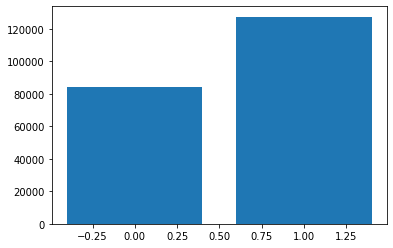

1    127452
0     84242
Name: Labels, dtype: int64

In [157]:
# summarize distribution
def print_dist(data):
  counter = Counter(data)
  # plot the distribution
  plt.bar(counter.keys(), counter.values())
  plt.show()

print_dist(y)
y.value_counts()

# **Data Partition**

In [158]:
# Spliting into training and testing
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, stratify = y) 

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((148185, 30), (148185,), (63509, 30), (63509,))

## **Oversample data**
 **Upsampling minor classes in training set to ensure the algs can learn from a balanced data**

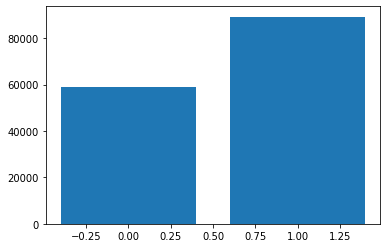

Max Class 1 has 89216 cases
Second Max Class len 58969


Before upsampling minor classes: (58969, 31)
After upsampling: (89216, 31) 



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


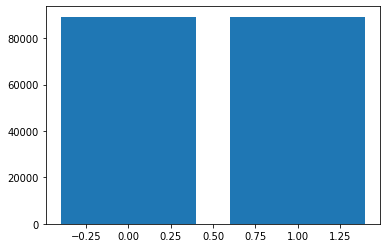

In [159]:
def over_sample(data, label):
  print_dist(label)

  ## Make sure y_train is balanced by upsampling minor classes up to the second biggest class

  # Look for the second biggest class
  label_dist = label.value_counts()
  max = 0; max_class = 0; max_2, max_2_class = 0, 0
  for i in range(len(label_dist)):
    if label_dist[i] > max:
      max_2 = max
      max_2_class = max_class
      max = label_dist[i]
      max_class = i
    elif max_2 < label_dist[i] < max:
      max_2 = label_dist[i]
      max_2_class = i

  print('Max Class %d has %d cases\nSecond Max Class len %d' % (max_class, max, max_2) )

  # Upsample minor classes upto the second biggest class
  filt = label == max_class
  #filt2 = label == max_2_class
  #major_y_train = label.loc[filt].append(label.loc[filt2])
  major_y_train = label.loc[filt]
  major_train = data.loc[data.index.isin(major_y_train.index)]

  # get the complement of the major classes indices
  minor_train = data.loc[~data.index.isin(major_y_train.index)]
  # get minor labels
  minor_train['Labels'] = label.loc[label.index.isin(minor_train.index)]
  #df[~df.index.isin(df_a.index+df_b.index)]
  print('\n\nBefore upsampling minor classes:', minor_train.shape)

  minor_train = minor_train.groupby('Labels').sample(n = max, replace=True) 
  minor_y_train = minor_train['Labels']
  print('After upsampling:', minor_train.shape, '\n')

  data = major_train.append(minor_train.drop(columns='Labels'), ignore_index = True)
  label = major_y_train.append(minor_y_train, ignore_index=True )
  label.astype('int32')
  print_dist(label)

  return data, label

x_train, y_train = over_sample(x_train, y_train)
#x_test,  y_test  = over_sample(x_test, y_test)

In [160]:
# Binarize y_train and y_test
from sklearn.preprocessing import label_binarize

# Binarize the output
if n_classes > 2:
  encoded_y_train = pd.DataFrame(label_binarize(y_train, classes = label_range))
  encoded_y_test  = pd.DataFrame(label_binarize(y_test, classes = label_range))
else:
  encoded_y_train = y_train
  encoded_y_test  = y_test

print('n_classes:', n_classes)

x_train.shape, encoded_y_train.shape, x_test.shape, encoded_y_test.shape

n_classes: 2


((178432, 30), (178432,), (63509, 30), (63509,))

In [161]:
encoded_y_train

0         1
1         1
2         1
3         1
4         1
         ..
178427    0
178428    0
178429    0
178430    0
178431    0
Name: Labels, Length: 178432, dtype: int64

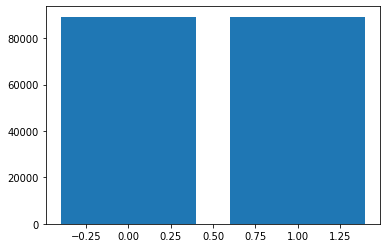

178432

In [162]:
# plot the distribution
counter = Counter(y_train)

plt.bar(counter.keys(), counter.values())
plt.show()
len(y_train)

In [163]:
print('TRAIN',y_train.value_counts())
class_w =  y_test.value_counts()
print('TEST', class_w)

TRAIN 1    89216
0    89216
Name: Labels, dtype: int64
TEST 1    38236
0    25273
Name: Labels, dtype: int64


In [164]:
class_w.to_list()

[38236, 25273]


# **Performance Measures**


1.   Function calc_false_positive: Calculates FPR
2.   Function print_performance: Formats printing performance metrics and ROC curve for each model
3.   Function color_confusion_matrix: prints out a heatmap of confusion matrix in blue color scale
4.   Graphing overlaid ROC curves, where each one represents a model AUC score





In [165]:
from itertools import cycle

# Plot all ROC curves
def plot_ROC (performance_measures, labels_dict, model_name):
  plt.figure(figsize=(10,6))
  fpr = performance_measures.get('fpr')
  tpr = performance_measures.get('tpr')
  roc_auc = performance_measures.get('auc')
  colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'deeppink', 'green'])

  if n_classes > 2:
    plt.plot( fpr["micro"] , tpr["micro"], 
            label='micro-average (AUC = {0:0.4f})'.format(roc_auc["micro"]),
            color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
            label='macro-average (AUC = {0:0.4f})'.format(roc_auc["macro"]),
            color='navy', linestyle=':', linewidth=4)

    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                label='{0} (AUC = {1:0.4f})'
                ''.format(labels_dict[i], roc_auc[i]))
  else:
    plt.plot(fpr, tpr, lw=2,
                label='AUC = {0:0.4f}'.format(roc_auc))

  plt.plot([0, 1], [0, 1], 'k--', lw=2)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC of multi-class using '+ model_name)
  plt.legend(loc="lower right",fancybox=True, shadow=True, ncol=2, fontsize = 10)
  plt.show()

def get_cmatrix(model_name ,true_labels, pred_labels):
  if n_classes <= 2:
    return confusion_matrix(true_labels, pred_labels)
  else:
    return confusion_matrix(true_labels.values.argmax(axis=1), pred_labels.argmax(axis=1))
  

# This function prints performance metrics and ROC curve given the model name, true labels and predicted labels
def print_performance( model_name, true_labels, pred_labels, label_names):
  # rows are actual, columns are predicted
  #cmatrix = confusion_matrix(true_labels.values.argmax(axis=1), pred_labels.argmax(axis=1))
  cmatrix = get_cmatrix(model_name, true_labels, pred_labels)

  print('Confusion Matrix: \n',cmatrix)
  print('\nClassification report:', classification_report(true_labels, pred_labels, target_names = label_names, zero_division=0), sep='\n')
  print('\nTesting Accuracy: %.2f'% accuracy_score(true_labels, pred_labels))
  print('Micro AUC: %.4f'% roc_auc_score(true_labels, pred_labels, average='micro', multi_class='ovr'))
  print('Macro AUC: %.4f'% roc_auc_score(true_labels, pred_labels, average='macro', multi_class='ovr'))

# Plot a heatmap of confusion matrix given the model name, a classifier model, testing data and the predicted label
def color_confusion_matrix(model_name, true_labels, pred_labels, labels):
  plt.figure(figsize=(10,10))
  #cmatrix = confusion_matrix(true_labels.values.argmax(axis=1), pred_labels.argmax(axis=1))
  cmatrix = get_cmatrix(model_name, true_labels, pred_labels)
  rows, cols = cmatrix.shape

  plt.figure(figsize=(8,8))
  plt.imshow(cmatrix, interpolation='nearest', cmap=plt.cm.Blues)
  plt.title('Confusion Matrix of '+ model_name)
  plt.colorbar()
  tick_marks = np.arange(len(labels))
  plt.xticks(tick_marks, labels, rotation=90)
  plt.yticks(tick_marks, labels)
  plt.xlabel('Predicted Labels')
  plt.ylabel('Actual Labels')
 
  large_vals = cmatrix.max()/2  #comment out because there are too many classes --> no need number
  for i in range(rows):
    for j in range(cols):
      if cmatrix[i, j] >= large_vals:
        color='white'
      else:
        color = 'black'
      plt.text(j, i, cmatrix[i, j], horizontalalignment = 'center', color= color)
  

## Record fpr, tpr and roc_auc info of each model on each class
def record_measures(true_labels, pred_labels):
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  if n_classes > 2:
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(true_labels.iloc[:, i], pred_labels[:, i])  
        roc_auc[i] = auc(fpr[i], tpr[i])

        #if np.isnan( roc_auc[i] ):
        #  roc_auc[i] = 0.5
        print('ROC AUC Class ',i,':', roc_auc[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve( true_labels.to_numpy().reshape(-1), pred_labels.reshape(-1))
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Compute macro-avg ROC curve and area
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    measures = {}
    measures['fpr'], measures['tpr'] = fpr, tpr
    measures['auc'] = roc_auc
    
  else:
    #print('Binary classification')
    measures = {}
    measures['fpr'], measures['tpr'], thresh = roc_curve(true_labels, pred_labels)
    measures['auc'] = auc(measures['fpr'], measures['tpr'])

  return measures
  

# Calculate either avg fpr or tpr given A DICT performance measurements of a model
# key_str can be: fpr, tpr, auc  ==== DEL
def get_ROC_info(info, key_str):
  fpr = info.get(key_str)
  fpr_arr = []
  for key in fpr:
    if key_str == 'auc':
      fpr_arr.append(fpr[key])
    elif key != 'micro' and key != 'macro':
      if len(fpr[key]) == 2: # incase some fpr only has [0, 1]
        #print('has < 2 elements', fpr[key], type(fpr[key]))
        fpr[key] = np.insert( fpr[key], 1, 0)
      fpr_arr.append(fpr[key])
    

  # Stack the fpr of each class on top of each other
  #print('get ROC info', key_str)
  #print(fpr_arr)
  fpr_arr = pd.DataFrame(np.row_stack(fpr_arr))

  # Get avg fpr
  return fpr_arr.mean().tolist()

# Save avg fpr, tpr and auc of a model to a dict ===== DEL
def combine_ROC_info(info):
  model_dict = {}
  model_dict['tpr'] = get_ROC_info(info, 'tpr')
  model_dict['fpr'] = get_ROC_info(info, 'fpr')
  model_dict['auc'] = get_ROC_info(info, 'auc')
  return model_dict


# Graphing overlaid ROC curves, where each one represents a model AUC score
def graph_multi_ROC (roc_type = 'micro'):
  # Set color for each model
  colors = {'DT': 'magenta','RF': 'green','KNN': 'darkturquoise', 'BERT': 'deeppink', 
            'GPT': 'deeppink', 'LGBM': 'lightcoral', 'XGB': 'blue'}
  # Set marker for each model          
  markers = { 'DT': 'o--', 'RF': '+--', 'KNN': '.--', 'BERT':'<--', 'GPT': '>--',
             'LGBM': '1--', 'XGB': '2--'}
  
  plt.figure(figsize=(9,6))
## need to get the average fpr and tpr of all class
  if n_classes > 2:
    DT_fpr = DT_test.get('fpr')[roc_type];    DT_tpr = DT_test.get('tpr')[roc_type]; DT_auc = DT_test.get('auc')[roc_type]
    #print(DT, DT_auc)
    RF_fpr = RF_test.get('fpr')[roc_type];    RF_tpr = RF_test.get('tpr')[roc_type];    RF_auc  = RF_test.get('auc')[roc_type]
    KNN_fpr = KNN_test.get('fpr')[roc_type];  KNN_tpr = KNN_test.get('tpr')[roc_type];  KNN_auc = KNN_test.get('auc')[roc_type]
    LGBM_fpr = LGBM_test.get('fpr')[roc_type];LGBM_tpr = LGBM_test.get('tpr')[roc_type];LGBM_auc= LGBM_test.get('auc')[roc_type]
    XGB_fpr = XGB_test.get('fpr')[roc_type];  XGB_tpr = XGB_test.get('tpr')[roc_type];  XGB_auc = XGB_test.get('auc')[roc_type]
    BERT_fpr = BERT_test.get('fpr')[roc_type];BERT_tpr = BERT_test.get('tpr')[roc_type];BERT_auc= BERT_test.get('auc')[roc_type]
  else:
    DT_fpr = DT_test.get('fpr');      DT_tpr = DT_test.get('tpr');    DT_auc = DT_test.get('auc')
    RF_fpr = RF_test.get('fpr');      RF_tpr = RF_test.get('tpr');    RF_auc = RF_test.get('auc')
    KNN_fpr = KNN_test.get('fpr');    KNN_tpr = KNN_test.get('tpr');  KNN_auc = KNN_test.get('auc')
    LGBM_fpr = LGBM_test.get('fpr');  LGBM_tpr = LGBM_test.get('tpr'); LGBM_auc = LGBM_test.get('auc')
    XGB_fpr = XGB_test.get('fpr');    XGB_tpr = XGB_test.get('tpr');  XGB_auc = XGB_test.get('auc')
    BERT_fpr = BERT_test.get('fpr');  BERT_tpr = BERT_test.get('tpr');BERT_auc = BERT_test.get('auc')

  plt.plot(DT_fpr, DT_tpr,   markers.get('DT'),  color=colors.get('DT'),  label="DT - AUC=" + str( round(DT_auc, 4) )) 
  plt.plot(RF_fpr,  RF_tpr,  markers.get('RF'),  color=colors.get('RF'),  label="RF - AUC=" + str( round(RF_auc, 4) ))
  plt.plot(KNN_fpr, KNN_tpr, markers.get('KNN'), color=colors.get('KNN'), label="KNN - AUC="+ str( round(KNN_auc, 4) ))
  plt.plot(LGBM_fpr,LGBM_tpr,markers.get('LGBM'),color=colors.get('LGBM'),label="LGBM - AUC=" +str( round(LGBM_auc, 4) ))
  plt.plot(XGB_fpr, XGB_tpr, markers.get('XGB'), color=colors.get('XGB'), label="XGB - AUC="+ str( round(XGB_auc,4) ))

  plt.plot(BERT_fpr, BERT_tpr, markers.get('BERT'), color=colors.get('BERT'),label="BERT - AUC="+ str( round(BERT_auc,4) ))
  #plt.plot(GPT_test.get('fpr'),GPT_test.get('tpr'), markers.get('GPT'), color=colors.get('GPT'),  label="GPT-2 - AUC="+ str(GPT_test.get('auc').round(3)))

  plt.plot([0,1], [0,1], 'k--', label='Random Chances')
  plt.xlim([0.0,1.0])
  plt.ylim([0.0,1.02])
  plt.ylabel('Recall')
  plt.xlabel('False Positive Rate (1-Specificity)')
  plt.legend(loc='lower right',fontsize= 10) 
  plt.title( 'Testing '+ roc_type+' ROCs on ' + DATA)
  plt.show()

# **Decision Tree**


TESTING
Confusion Matrix: 
 [[25259    14]
 [   15 38221]]

Classification report:
              precision    recall  f1-score   support

      BENIGN       1.00      1.00      1.00     25273
        DDoS       1.00      1.00      1.00     38236

    accuracy                           1.00     63509
   macro avg       1.00      1.00      1.00     63509
weighted avg       1.00      1.00      1.00     63509


Testing Accuracy: 1.00
Micro AUC: 0.9995
Macro AUC: 0.9995


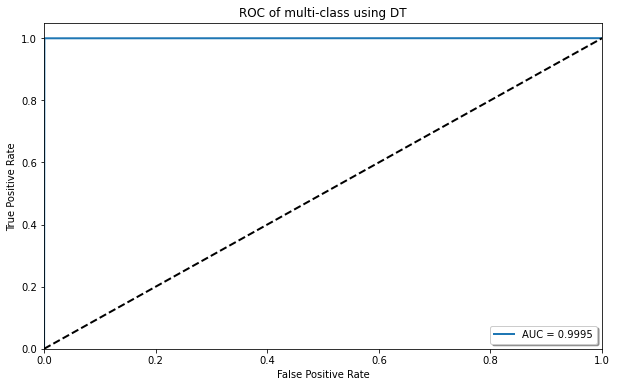

Train AUC: 0.9998 vs Test AUC: 0.9995


In [166]:
from sklearn.tree import DecisionTreeClassifier

# Create and Train DecTree model
decTree = DecisionTreeClassifier(criterion='gini', min_samples_split=10,min_samples_leaf=5,max_features='auto')
decTree = decTree.fit(x_train, encoded_y_train)

# Recording TPR and FPR for the TRAINING ROC curves
y_pred = decTree.predict(x_train)
DT_train = record_measures(encoded_y_train, y_pred)


# Predict testing data
y_predicted = decTree.predict(x_test)

# Print performance measures
print('\nTESTING')
print_performance('Decision Tree', encoded_y_test, y_predicted, OG_labels)

# Recording TPR and FPR for TESTING-ROC curves
DT_test = record_measures(encoded_y_test, y_predicted)

# Print ROC Curve
plot_ROC(DT_test, labels_dict, 'DT')
if n_classes > 2:
  print('Train AUC: %.4f vs Test AUC: %.4f' %(DT_train['auc']['micro'], DT_test['auc']['micro']))
else:
  print('Train AUC: %.4f vs Test AUC: %.4f' %(DT_train['auc'], DT_test['auc']))



<Figure size 720x720 with 0 Axes>

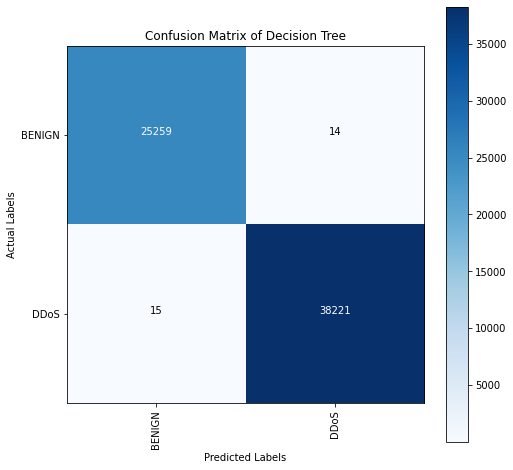

In [167]:
# Color Confusion Matrix
color_confusion_matrix('Decision Tree', encoded_y_test, y_predicted, OG_labels)

# **Random Forest**


TESTING
Confusion Matrix: 
 [[25271     2]
 [    2 38234]]

Classification report:
              precision    recall  f1-score   support

      BENIGN       1.00      1.00      1.00     25273
        DDoS       1.00      1.00      1.00     38236

    accuracy                           1.00     63509
   macro avg       1.00      1.00      1.00     63509
weighted avg       1.00      1.00      1.00     63509


Testing Accuracy: 1.00
Micro AUC: 0.9999
Macro AUC: 0.9999


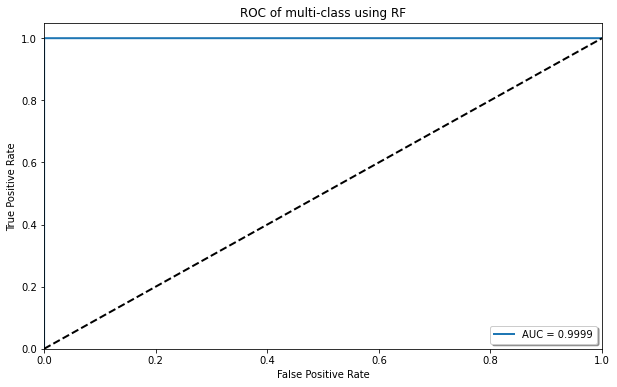

Train AUC: 0.9999 vs Test AUC: 0.9999


In [168]:
from sklearn.ensemble import RandomForestClassifier

# Build model
randomForest = RandomForestClassifier(max_depth=None, min_samples_split=10, min_samples_leaf=5, 
                                      max_features='auto', bootstrap=True,verbose=0, criterion='gini')
# Train the model with training set
randomForest.fit(x_train, encoded_y_train)

# Recording TPR and FPR for the TRAINING ROC curves
y_pred = randomForest.predict(x_train)
RF_train = record_measures(encoded_y_train, y_pred)

# Predict the labels for testing set
y_predicted = randomForest.predict(x_test)

# Print performance measures
print('\nTESTING')
print_performance('Random Forest', encoded_y_test, y_predicted, OG_labels)

# Recording TPR and FPR for the multi-ROC curves
RF_test = record_measures(encoded_y_test, y_predicted)

# Print ROC Curve
plot_ROC(RF_test, labels_dict, 'RF')
if n_classes > 2:
  print('Train AUC: %.4f vs Test AUC: %.4f' %(RF_train['auc']['micro'], RF_test['auc']['micro']))
else:
  print('Train AUC: %.4f vs Test AUC: %.4f' %(RF_train['auc'], RF_test['auc']))


In [169]:
RF_test

{'auc': 0.9999342787183456,
 'fpr': array([0.00000000e+00, 7.91358367e-05, 1.00000000e+00]),
 'tpr': array([0.        , 0.99994769, 1.        ])}

<Figure size 720x720 with 0 Axes>

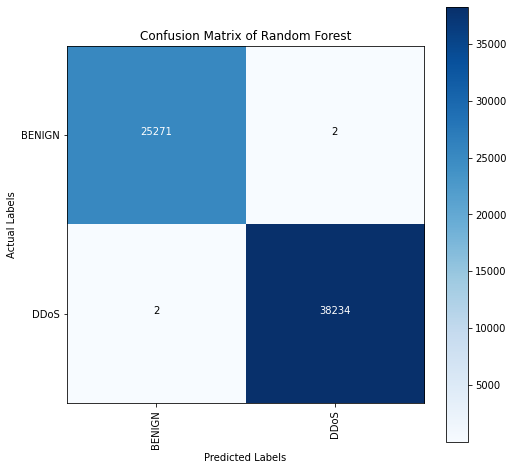

In [170]:
# Color Confusion Matrix
color_confusion_matrix('Random Forest', encoded_y_test, y_predicted, OG_labels)

# **KNN**

Since KNN takes longer to classify this amount of data, we randomly sample 10K normal rows and 10K intrusion rows to train and test KNN.

Confusion Matrix: 
 [[24690   583]
 [  297 37939]]

Classification report:
              precision    recall  f1-score   support

      BENIGN       0.99      0.98      0.98     25273
        DDoS       0.98      0.99      0.99     38236

    accuracy                           0.99     63509
   macro avg       0.99      0.98      0.99     63509
weighted avg       0.99      0.99      0.99     63509


Testing Accuracy: 0.99
Micro AUC: 0.9846
Macro AUC: 0.9846


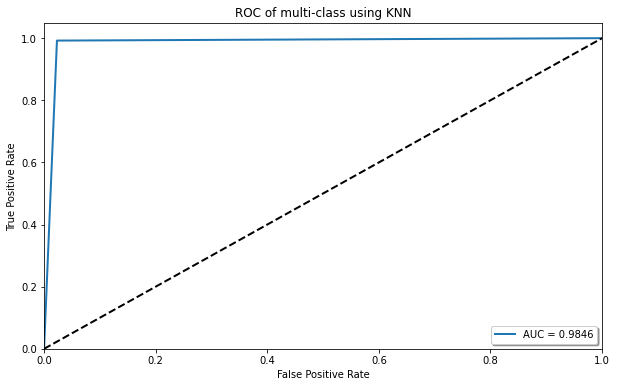

Train AUC: 0.9963 vs Test AUC: 0.9846


In [171]:
from sklearn.neighbors import KNeighborsClassifier

# Creat and Train KNN model
KNN = KNeighborsClassifier(n_neighbors=3, weights='uniform')
KNN.fit(x_train, encoded_y_train)

# Recording TPR and FPR for the TRAINING ROC curves
y_pred = KNN.predict(x_train)
KNN_train = record_measures(encoded_y_train, y_pred)

# Predict testing data
y_predicted = KNN.predict(x_test)

# Print performance measures
print_performance('KNN', encoded_y_test, y_predicted, OG_labels)

# Recording TPR and FPR for TESTING-ROC curves
KNN_test = record_measures( encoded_y_test, y_predicted)

# Print ROC Curve
plot_ROC(KNN_test, labels_dict, 'KNN')
if n_classes > 2:
  print('Train AUC: %.4f vs Test AUC: %.4f' %(KNN_train['auc']['micro'], KNN_test['auc']['micro']))
else:
  print('Train AUC: %.4f vs Test AUC: %.4f' %(KNN_train['auc'], KNN_test['auc']))

<Figure size 720x720 with 0 Axes>

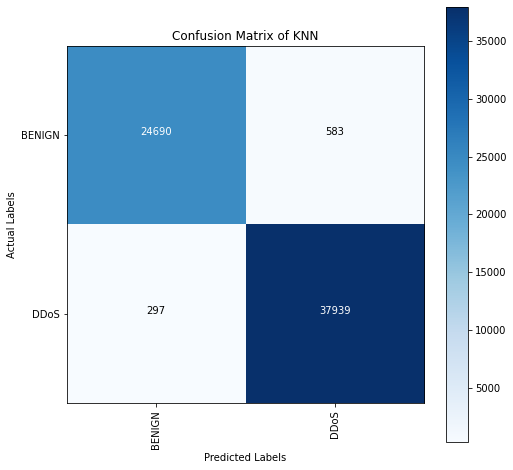

In [172]:
# Color Confusion Matrix
color_confusion_matrix('KNN', encoded_y_test, y_predicted, OG_labels)

# **LightGBM**

Note: LightGBM can only be trained with labels 0,1,2,3,4,5, etc. not binarized labels

Confusion Matrix: 
 [[25272     1]
 [    1 38235]]

Classification report:
              precision    recall  f1-score   support

      BENIGN       1.00      1.00      1.00     25273
        DDoS       1.00      1.00      1.00     38236

    accuracy                           1.00     63509
   macro avg       1.00      1.00      1.00     63509
weighted avg       1.00      1.00      1.00     63509


Testing Accuracy: 1.00
Micro AUC: 1.0000
Macro AUC: 1.0000


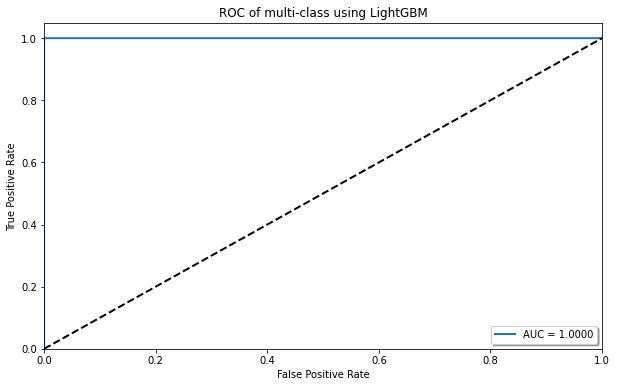

Train AUC: 1.0000 vs Test AUC: 1.0000


In [173]:
from lightgbm import LGBMClassifier

# Train LightGBM Classifier
if n_classes > 2:
  lgbmc = LGBMClassifier(objective= 'multiclass')
 
  #y_pred = label_binarize(y_pred, classes= label_range)
else:
  lgbmc = LGBMClassifier(objective= 'binary')
  
lgbmc.fit(x_train, y_train)
y_pred = lgbmc.predict(x_train)
y_pred = label_binarize(y_pred, classes= label_range)

# Recording TPR and FPR for TRAINING-ROC curves
LGBM_train = record_measures(encoded_y_train, y_pred)

# Predict test data
y_predicted = lgbmc.predict(x_test)

# Encode y_predicted:
y_pred_encoded = label_binarize(y_predicted, classes= label_range)

# Print performance measures
print_performance('LightGBM', encoded_y_test, y_pred_encoded, OG_labels)

# Recording TPR and FPR for TESTING-ROC curves
LGBM_test = record_measures(encoded_y_test, y_pred_encoded)

# Print ROC Curve
plot_ROC(LGBM_test, labels_dict, 'LightGBM')
if n_classes > 2:
  print('Train AUC: %.4f vs Test AUC: %.4f' %(LGBM_train['auc']['micro'], LGBM_test['auc']['micro']))
else:
  print('Train AUC: %.4f vs Test AUC: %.4f' %(LGBM_train['auc'], LGBM_test['auc']))

<Figure size 720x720 with 0 Axes>

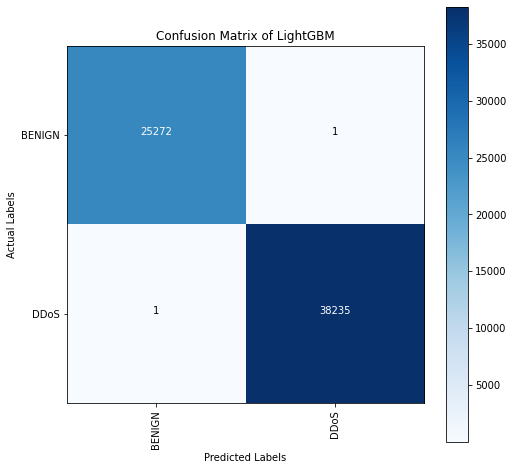

In [174]:
# Color Confusion Matrix
color_confusion_matrix('LightGBM', encoded_y_test, y_pred_encoded, OG_labels)

# **XGBoost**



Testing Result of XGBoost:
Confusion Matrix: 
 [[25269     4]
 [    6 38230]]

Classification report:
              precision    recall  f1-score   support

      BENIGN       1.00      1.00      1.00     25273
        DDoS       1.00      1.00      1.00     38236

    accuracy                           1.00     63509
   macro avg       1.00      1.00      1.00     63509
weighted avg       1.00      1.00      1.00     63509


Testing Accuracy: 1.00
Micro AUC: 0.9998
Macro AUC: 0.9998


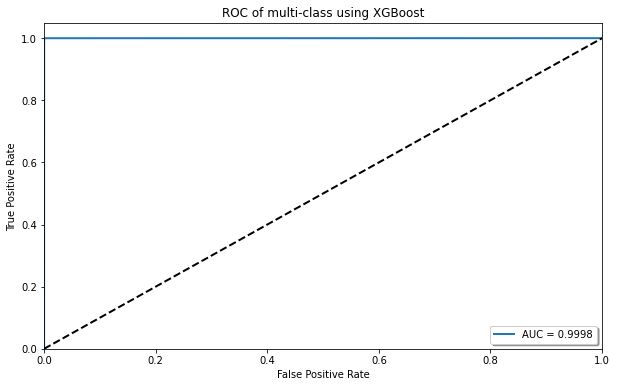

Train AUC: 0.9998 vs Test AUC: 0.9998


In [175]:
from xgboost import XGBClassifier

# Train XGBoost Classifier
xgb = XGBClassifier(eval_metric="logloss")

xgb.fit(x_train, y_train)
y_pred = xgb.predict(x_train)
y_pred = label_binarize(y_pred, classes= label_range)


# Recording TPR and FPR for TRAINING-ROC curves
XGB_train = record_measures(encoded_y_train, y_pred)

# Predict test data
y_predicted = xgb.predict(x_test)

# Encode y_predicted:
y_pred_encoded = label_binarize(y_predicted, classes= label_range)

# Print performance measures
print('\n\nTesting Result of XGBoost:')
print_performance('LightGBM', encoded_y_test, y_pred_encoded, OG_labels)

# Recording TPR and FPR for TESTING-ROC curves
XGB_test = record_measures(encoded_y_test, y_pred_encoded)

# Print ROC Curve
plot_ROC(XGB_test, labels_dict, 'XGBoost')
if n_classes > 2:
  print('Train AUC: %.4f vs Test AUC: %.4f' %(XGB_train['auc']['micro'], XGB_test['auc']['micro']))
else:
  print('Train AUC: %.4f vs Test AUC: %.4f' %(XGB_train['auc'],XGB_test['auc']))


<Figure size 720x720 with 0 Axes>

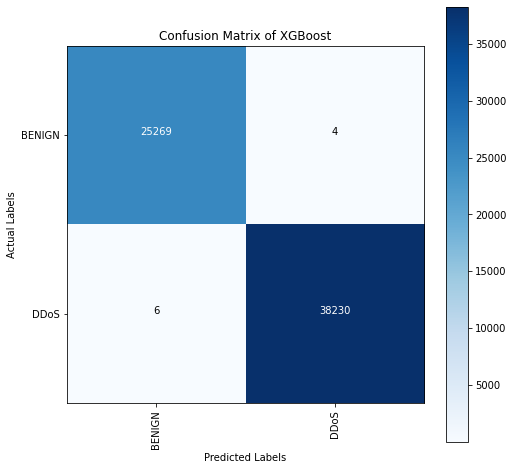

In [176]:
# Color Confusion Matrix
color_confusion_matrix('XGBoost', encoded_y_test, y_pred_encoded, OG_labels)

 Ploting the overlaid ROC curves on testing results:
graph_multi_ROC()

graph_multi_ROC()

# **BERT**


# **Multi-class BERT**

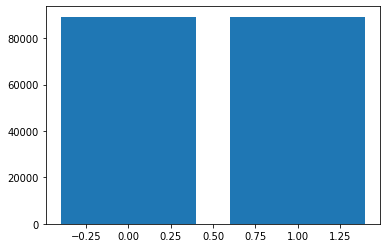

In [177]:
# plot the distribution
counter = Counter(y_train)

plt.bar(counter.keys(), counter.values())
plt.show()

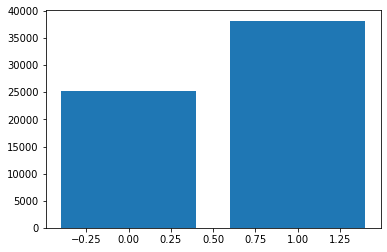

In [178]:
# plot the distribution
counter = Counter(y_test)

plt.bar(counter.keys(), counter.values())
plt.show()

## **Combining all features into a sentence**

In [179]:
y_train.value_counts()

1    89216
0    89216
Name: Labels, dtype: int64

train_data = x_train.append(y_train, ignore_index = False)
train_data
#print(len(x_sub), len(y_sub))

In [180]:
train_texts = []
for i in range(x_train.shape[0]):
     train_texts.append(" ".join(np.array(x_train.iloc[i,:]).astype(str)))
train_texts = tuple(train_texts) 


In [181]:
train_texts

('1934.5 1934.5 4380.0 2177.344966 80.0 0.0 1163.3 1292.555556 1903.962654 0.0 4380.0 3625073.789 20.0 0.0 8.666666667000001 8.666666667000001 20.0 26.0 26.0 578706.0 2.0 10.26320288 577823.0 258311.8082 1.0 0.0 0.0 115741.2 0.0 204241.0432',
 '2321.4 2321.4 10135.0 4413.201989 80.0 0.0 1292.555556 1454.125 3350.634907 0.0 10135.0 11200000.0 20.0 0.0 8.666666667000001 8.666666667000001 20.0 26.0 26.0 1016323.0 1.0 10.26320288 1015563.0 507654.88700000005 1.0 0.0 0.0 254080.75 0.0 383796.1249',
 '1933.5 1933.5 5840.0 2189.7729329999997 80.0 0.0 1162.7 1291.888889 1911.59573 0.0 5840.0 3654198.233 20.0 0.0 8.666666667000001 8.666666667000001 20.0 26.0 26.0 330861.0 2.0 10.26320288 300767.0 131771.875 1.0 0.0 0.0 66172.2 0.0 105321.6353',
 '2320.2 2320.2 8760.0 3668.897 80.0 0.0 1291.888889 1453.375 2866.607422 0.0 8760.0 8217438.1110000005 20.0 0.0 8.666666667000001 8.666666667000001 20.0 26.0 26.0 365257.0 1.0 10.26320288 340331.0 166407.6823 1.0 0.0 0.0 91314.25 0.0 127380.4974',
 '0.0

In [182]:
test_texts = []
for i in range(x_test.shape[0]):
     test_texts.append(" ".join(np.array(x_test.iloc[i,:]).astype(str)))
test_texts = tuple(test_texts)

In [183]:
encoded_y_train.head()

0    1
1    1
2    1
3    1
4    1
Name: Labels, dtype: int64

In [184]:
!pip install transformers

# Load Huggingface transformers
from transformers import TFBertModel,  BertConfig, BertTokenizerFast
# Then what you need from tensorflow.keras
from tensorflow.keras.layers import Input, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical

In [185]:
### --------- Setup BERT ---------- ###
# Name of the BERT model to use
model_name = 'bert-base-uncased'
# Max length of tokens
if len(X.columns) > 30:
  max_length = 50
elif 20<= len(X.columns) <= 30:
  max_length =  40
elif 10 < len(X.columns) < 20:
  max_length = 30
else:
  max_length = 9 # for the rest of the datasets

if INDEX == 2:
  max_length = 6 # for dataset index 2

# Load transformers config and set output_hidden_states to False
config = BertConfig.from_pretrained(model_name)
config.output_hidden_states = False

# Load BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained(pretrained_model_name_or_path = model_name, config = config)

# Load the Transformers BERT model
transformer_model = TFBertModel.from_pretrained(model_name, config = config)

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [186]:
### ------- Build the model ------- ###

# TF Keras documentation: https://www.tensorflow.org/api_docs/python/tf/keras/Model

# Load the MainLayer
bert = transformer_model.layers[0]

# Build your model input
input_ids = Input(shape=(max_length,), name='input_ids', dtype='int32')
inputs = {'input_ids': input_ids}

# Load the Transformers BERT model as a layer in a Keras model
bert_model = bert(inputs)[1]
dropout = Dropout(config.hidden_dropout_prob, name='pooled_output')
pooled_output = dropout(bert_model, training=False)

# Then build your model output
label = Dense(units=len(label_range), kernel_initializer=TruncatedNormal(stddev=config.initializer_range), name='label')(pooled_output)
#product = Dense(units=len(data.Product_label.value_counts()), kernel_initializer=TruncatedNormal(stddev=config.initializer_range), name='product')(pooled_output)
outputs = {'label': label}

# And combine it all in a model object
model = Model(inputs=inputs, outputs=outputs, name='BERT_MultiLabel_MultiClass')

# Take a look at the model
model.summary()

Model: "BERT_MultiLabel_MultiClass"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 40)]              0         
_________________________________________________________________
bert (TFBertMainLayer)       TFBaseModelOutputWithPool 109482240 
_________________________________________________________________
pooled_output (Dropout)      (None, 768)               0         
_________________________________________________________________
label (Dense)                (None, 2)                 1538      
Total params: 109,483,778
Trainable params: 109,483,778
Non-trainable params: 0
_________________________________________________________________


In [ ]:
### ------- Train the model ------- ###

# Set an optimizer
optimizer = Adam(
    learning_rate=5e-05,
    epsilon=1e-08,
    decay=0.01,
    clipnorm=1.0)

# Set loss and metrics
loss = {'label': CategoricalCrossentropy(from_logits = True)}
metric = {'label': CategoricalAccuracy('accuracy')}

# Compile the model
model.compile(
    optimizer = optimizer,
    loss = loss, 
    metrics = metric)

# Ready output data for the model
if n_classes == 2:
  encoded_labels = to_categorical(encoded_y_train)
else:
  encoded_labels = encoded_y_train

# Tokenize the input (takes some time)
x = tokenizer(
    text= list(train_texts),
    add_special_tokens=True,
    max_length=max_length,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = False,
    verbose = True)

# Fit the model
history = model.fit(
    x={'input_ids': x['input_ids']},
    y={'label': encoded_labels},
    validation_split=0.2,
    batch_size=128,
    epochs = 2)

Epoch 1/2
1116/1116 [==============================] - 1177s 1s/step - loss: 0.0085 - accuracy: 0.9981 - val_loss: 0.0012 - val_accuracy: 0.9996
Epoch 2/2
 395/1116 [=========>....................] - ETA: 11:38 - loss: 0.0017 - accuracy: 0.9996

In [ ]:
y_train_pred = model.predict(x={'input_ids': x['input_ids']}, verbose = 1)

y_train_pred_encoded = label_binarize(y_train_pred['label'].argmax(axis=1), classes= label_range)

# Recording TPR and FPR for TRAINING-ROC curves
if n_classes > 2:
  BERT_train = record_measures( encoded_y_train, y_train_pred_encoded) 
else:
  BERT_train = record_measures( y_train, y_train_pred_encoded) 

In [ ]:
### ----- Evaluate the model ------ ###

# Ready test data
if n_classes == 2:
  encoded_test_labels = to_categorical(encoded_y_test)
else:
  encoded_test_labels = encoded_y_test

test_x = tokenizer(
    text= list(test_texts),
    add_special_tokens=True,
    max_length=max_length,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = False,
    verbose = True)

# Run evaluation
model_eval = model.evaluate(
    x={'input_ids': test_x['input_ids']},
    y={'label': encoded_test_labels}
)

In [ ]:
y_predicted = model.predict( x={'input_ids': test_x['input_ids']}, verbose=1 )

# Encode y_predicted: ***************************
y_pred_encoded = label_binarize(y_predicted['label'].argmax(axis=1), classes= label_range)
#y_pred_encoded, encoded_y_test

In [ ]:
# Print performance measures
if n_classes > 2:
  print_performance('BERT', encoded_y_test, y_pred_encoded, OG_labels)
  BERT_test = record_measures( encoded_y_test, y_pred_encoded)    # Recording TPR and FPR for TESTING-ROC curves
else:
  print_performance('BERT', y_test, y_pred_encoded, OG_labels)
  BERT_test = record_measures( y_test, y_pred_encoded)            # Recording TPR and FPR for TESTING-ROC curves

# Print ROC Curve
plot_ROC(BERT_test, labels_dict, 'BERT')


if n_classes > 2:
  print('Train AUC: %.4f vs Test AUC: %.4f' %(BERT_train['auc']['micro'], BERT_test['auc']['micro']))
else:
  print('Train AUC: %.4f vs Test AUC: %.4f' %(BERT_train['auc'],BERT_test['auc']))

In [ ]:
# Color Confusion Matrix
if n_classes > 2:
  color_confusion_matrix('BERT', encoded_y_test, y_pred_encoded, OG_labels)
else:
  color_confusion_matrix('BERT', y_test, y_pred_encoded, OG_labels)


# **GPT-2**

In [ ]:
BERT_test

# **Graphing multi-ROC Curves**

In [ ]:
# Ploting the overlaid ROC curves on testing results:
# Graph micro AUC
graph_multi_ROC()

# Graph macro AUC
graph_multi_ROC('macro')

# **NOTE After Preventing Overfitting**
**No need to scale data because BERT doesn't work well with that**

0 - Friday-WorkingHours-Afternoon-DDos: has 30 col features and 2 classes. Intrusion class is dominant in this dataset and it is nearly balanced with over 127K DDoS instances and over 84K normal instances. As a result, all algorithms perform very well with AUC above 0.999, except KNN 0.985. Also, all algorithms except KNN achieves 1 in accuracy, precision, recall and Macro F1-Score.

1 - Friday-WorkingHours-Afternoon-PortScan: has 30 col features and 2 classes. This dataset has no overlap records between 2 classes. There are almost 116K normal instances along with almost 2K PortScan instances. All algs perform very well with AUC above 0.98.

2 - Friday-WorkingHours-Morning: has 3 col features and 2 classes. This dataset is not so imbalanced. There are 1936 unique intrusion instances and over 160K normal instances. The algs perform well (AUC above 0.92 except BERT 0.82). 

3 - Monday: Only contains normal class, so we did not analyze it.

4 - Thursday-WorkingHours-Afternoon-Infilteration: has 13 col features and 2 classes. All multiclass classifiers perform poorly (AUC below 0.60 except XGB 0.74). This is due to lack of unique intrusion instances. There are almost 50K normal instances and only 35 unique intrusion instances. 

5 - Thursday-WorkingHours-Morning-WebAttacks: has 3 col features and 4 classes and all multiclass classifiers perform adequately (AUC around 0.70). All algs misclassified Brute Force for XSS because they have very similar values in the best features. This is also because this dataset is extremely imbalance, where each intrusion class only has 22 unique instances or less and normal class has over 16K instances. After splitting, the test set only contains 13 instances from all intrusion classes while it contains 5058 normal instances.

6 - Tuesday Working Hour: has 3 classes and all multiclass classifiers (including BERT) perform very well (AUC above 0.96). Normal data are dominant in this dataset (over 180K), while intrusion classes (FTP and SSH) have 626 cases amd 140 cases respectively. Therefore, the performance is really good comparing to the other imbalanced dataset.

7 - Wednesday Working Hour: has 5 classes and all classifiers (except BERT since we ran out of RAM while running BERT) perform very well (AUC above 0.99). This dataset is not too imbalanced. Each intrusion class has more than 5000 distinctive instances except heartbleed, which only has 11 instances.

